In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [49]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

In [51]:
players_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2023-24/players_raw.csv"
players_pd_all=pd.read_csv(players_url)
players_pd=players_pd_all[['first_name', 'second_name', 'team']]
players_pd.head(25)

,first_name,second_name,team
0,Folarin,Balogun,1
1,Cédric,Alves Soares,1
2,Mohamed,Elneny,1
3,Fábio,Ferreira Vieira,1
4,Gabriel,dos Santos Magalhães,1
5,Kai,Havertz,1
6,Gabriel,Fernando de Jesus,1
7,Jorge Luiz,Frello Filho,1
8,Jakub,Kiwior,1
9,Marcus,Oliveira Alencar,1


In [52]:
temp=pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2020-21/players_raw.csv")
temp.columns
#team_h_dif is the difficultly of the home team player

Index(['assists', 'bonus', 'bps', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'clean_sheets', 'code',
       'corners_and_indirect_freekicks_order',
       'corners_and_indirect_freekicks_text', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'creativity', 'creativity_rank', 'creativity_rank_type',
       'direct_freekicks_order', 'direct_freekicks_text', 'dreamteam_count',
       'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'goals_conceded', 'goals_scored', 'ict_index', 'ict_index_rank',
       'ict_index_rank_type', 'id', 'in_dreamteam', 'influence',
       'influence_rank', 'influence_rank_type', 'minutes', 'news',
       'news_added', 'now_cost', 'own_goals', 'penalties_missed',
       'penalties_order', 'penalties_saved', 'penalties_text', 'photo',
       'points_per_game', 'red_cards', 'saves', 'second_name',
       'selected_by_percent', 'special', 'squad_

In [491]:
def fetch_data(url, players_url, fix_url, teams_url):
    df = pd.read_csv(url, encoding="latin1")
    df2 = pd.read_csv(players_url)
    df_fix_raw=pd.read_csv(fix_url)
    df_teams_raw=pd.read_csv(teams_url)
    
    df[['first_name', 'second_name']] = df['name'].str.split(' ', n=1, expand=True)
    df2=df2[['first_name', 'second_name', 'team', 'web_name']]
    df_fix=df_fix_raw[['id', 'team_h_difficulty', 'team_a_difficulty']]
    df_teams=df_teams_raw[['name', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]
    
    
    if 'expected_assists' in df.columns:
        df.drop('expected_assists', axis=1, inplace=True)
        df.drop('expected_goal_involvements', axis=1, inplace=True)
        df.drop('expected_goals', axis=1, inplace=True)
        df.drop('expected_goals_conceded', axis=1, inplace=True)
        df.drop('starts', axis=1, inplace=True)

    df = df.sort_values(by=['name', 'GW'])
    df['form'] = (
    df.groupby('name')['total_points']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
    )
    df['form'] = df.groupby('name')['form'].transform(lambda x: x.fillna(0))
    # List of columns to update with cumulative sums
    columns_to_cumsum = ['goals_scored', 'assists', 'bonus', 'yellow_cards', 'clean_sheets', 'goals_conceded']

    # Apply cumulative sum for each column grouping by 'name', excluding the current row
    for col in columns_to_cumsum:
        df[col] = df.groupby('name')[col].cumsum().shift(1, fill_value=0)

    df.update(
    df.groupby('name')[columns_to_cumsum].transform(lambda x: x.mask(x.index == x.index.min(), 0))
    )

    df['cumulative_minutes'] = (
    df.groupby('name')['minutes']
    .cumsum()                # Compute cumulative sum
    .shift(1, fill_value=0)  # Shift down by 1 row, keeping first as 0
    )
    df['cumulative_minutes'] = df.groupby('name')['cumulative_minutes'].transform(
    lambda x: x.mask(x.index == x.index.min(), 0)
    )

    df = df.groupby('name').filter(lambda x: x['cumulative_minutes'].iloc[-1] >= 600)
    
    df=pd.merge(df, df_fix, left_on='fixture', right_on='id', how='left')
    
    df['fixture_difficulty']=np.where(df['was_home'], df['team_h_difficulty'], df['team_a_difficulty'])
    
    df=pd.merge(df, df_teams, left_on='team', right_on='name', how='left')
    df['strength_overall']=np.where(df['was_home'], df['strength_overall_home'], df['strength_overall_away'])
    df['strength_attack']=np.where(df['was_home'], df['strength_attack_home'], df['strength_attack_away'])
    df['strength_defence']=np.where(df['was_home'], df['strength_defence_home'], df['strength_defence_away'])
    
    df=df.drop(['team_h_difficulty', 'team_a_difficulty', 'team_a_score', 'team_h_score', 'opponent_team', 'xP', 'kickoff_time', 'element', 'fixture'], axis=1)
    merged_df=pd.merge(df, df2, on=['first_name', 'second_name'], how='inner')
    merged_df=merged_df.drop(['team_x', 'team_y', 'first_name', 'second_name', 'bps', 'round', 'name_y', 'id', 'minutes', 'own_goals', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'transfers_balance', 'GW', 'saves', 'penalties_missed', 'penalties_saved'],axis=1)
    print(merged_df.columns)
    gks=merged_df.loc[(merged_df['position']=="GK")]
    defs=merged_df.loc[(merged_df['position']=="DEF") ]
    mids=merged_df.loc[(merged_df['position']=="MID")]
    fwds=merged_df.loc[(merged_df['position']=="FWD") ]

    fwds=fwds.drop(['goals_conceded', 'clean_sheets', 'strength_defence'], axis=1)

    return gks, defs, mids, fwds

In [493]:
gks=[]
defs=[]
mids=[]
fwds=[]
gks_test=[]
defs_test=[]
mids_test=[]
fwds_test=[]

In [495]:
for i in range(20,23):
    gw_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/gws/merged_gw.csv"
    players_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/players_raw.csv"
    fixtures_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/fixtures.csv"
    teams_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/teams.csv"
    gks_temp, defs_temp, mids_temp, fwds_temp=fetch_data(gw_url, players_url, fixtures_url, teams_url)
    if i < 22:
        gks.append(gks_temp)
        defs.append(defs_temp)
        mids.append(gks_temp)
        fwds.append(fwds_temp)
    else:
        gks_test.append(gks_temp)
        defs_test.append(defs_temp)
        mids_test.append(gks_temp)
        fwds_test.append(fwds_temp)

Index(['name_x', 'position', 'assists', 'bonus', 'clean_sheets', 'creativity',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'red_cards',
       'selected', 'threat', 'total_points', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'form', 'cumulative_minutes',
       'fixture_difficulty', 'strength', 'strength_overall', 'strength_attack',
       'strength_defence', 'web_name'],
      dtype='object')
Index(['name_x', 'position', 'assists', 'bonus', 'clean_sheets', 'creativity',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'red_cards',
       'selected', 'threat', 'total_points', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'form', 'cumulative_minutes',
       'fixture_difficulty', 'strength', 'strength_overall', 'strength_attack',
       'strength_defence', 'web_name'],
      dtype='object')
Index(['name_x', 'position', 'assists', 'bonus', 'clean_sheets', 'creativity',
       'goals_c

In [496]:
gks_test=gks_test[0]
defs_test=defs_test[0]
mids_test=mids_test[0]
fwds_test=fwds_test[0]

In [497]:
pd.set_option('display.max_columns', None)
fwds_test.head(30)

,name_x,position,assists,bonus,creativity,goals_scored,ict_index,influence,red_cards,selected,threat,total_points,transfers_in,transfers_out,value,was_home,yellow_cards,form,cumulative_minutes,fixture_difficulty,strength,strength_overall,strength_attack,web_name
152,Adam Armstrong,FWD,0,0,0.8,0,0.0,0.0,0,58462,1.0,1,0,0,55,False,0,0.000000,0,4,2,1070,1070,A.Armstrong
153,Adam Armstrong,FWD,0,0,11.1,0,3.3,17.4,0,65627,4.0,4,9403,10310,55,True,0,1.000000,45,2,2,1065,1070,A.Armstrong
154,Adam Armstrong,FWD,1,0,1.3,0,0.8,2.6,0,80588,4.0,2,22460,14248,55,False,0,2.500000,74,3,2,1070,1070,A.Armstrong
155,Adam Armstrong,FWD,1,0,25.7,0,6.0,9.6,0,78732,25.0,2,10596,14561,55,True,0,2.333333,143,3,2,1065,1070,A.Armstrong
156,Adam Armstrong,FWD,1,0,0.9,0,6.8,39.2,0,78093,28.0,9,10850,14089,55,True,0,2.250000,219,3,2,1065,1070,A.Armstrong
157,Adam Armstrong,FWD,1,3,3.8,1,1.6,0.0,0,158394,15.0,2,86076,19907,55,False,0,3.600000,304,2,2,1070,1070,A.Armstrong
158,Adam Armstrong,FWD,1,3,0.6,1,1.2,9.6,0,161312,2.0,2,15971,13264,55,False,0,3.800000,386,2,2,1070,1070,A.Armstrong
159,Adam Armstrong,FWD,1,3,17.0,1,7.3,8.2,0,166199,48.0,1,21173,21776,55,True,0,3.400000,456,2,2,1065,1070,A.Armstrong
160,Adam Armstrong,FWD,1,3,13.0,1,1.3,0.2,0,139838,0.0,2,9235,35362,55,False,0,3.200000,486,5,2,1070,1070,A.Armstrong
161,Adam Armstrong,FWD,1,3,22.2,1,3.6,14.0,0,132945,0.0,2,5642,13855,55,True,0,3.200000,551,2,2,1065,1070,A.Armstrong


In [498]:
gks_test.head(40)

,name_x,position,assists,bonus,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,red_cards,selected,threat,total_points,transfers_in,transfers_out,value,was_home,yellow_cards,form,cumulative_minutes,fixture_difficulty,strength,strength_overall,strength_attack,strength_defence,web_name
76,Aaron Ramsdale,GK,0,0,0,0.0,0,0,1.9,19.0,0,1128297,0.0,6,0,0,50,False,0,0.000000,0,2,4,1285,1250,1320,Ramsdale
77,Aaron Ramsdale,GK,0,0,1,0.0,0,0,1.2,11.6,0,1369348,0.0,1,93632,62345,50,True,0,6.000000,90,3,4,1245,1250,1240,Ramsdale
78,Aaron Ramsdale,GK,0,0,1,0.0,2,0,0.8,7.6,0,1366505,0.0,6,88334,149693,50,False,0,3.500000,180,2,4,1285,1250,1320,Ramsdale
79,Aaron Ramsdale,GK,0,0,2,0.0,2,0,1.9,18.8,0,1422476,0.0,2,88190,100359,50,True,0,4.333333,270,2,4,1245,1250,1240,Ramsdale
80,Aaron Ramsdale,GK,0,0,2,0.0,3,0,1.7,17.4,0,1407588,0.0,2,48276,101616,50,True,0,3.750000,360,2,4,1245,1250,1240,Ramsdale
81,Aaron Ramsdale,GK,0,0,2,0.0,4,0,2.5,25.2,0,1164227,0.0,2,17642,267932,50,False,0,3.400000,450,4,4,1285,1250,1320,Ramsdale
82,Aaron Ramsdale,GK,0,0,2,0.0,7,0,1.8,17.8,0,1117890,0.0,6,26476,60112,49,False,0,2.600000,540,3,4,1285,1250,1320,Ramsdale
83,Aaron Ramsdale,GK,0,0,3,0.0,7,0,1.9,19.2,0,1109375,0.0,2,39331,71691,49,True,0,3.600000,630,3,4,1245,1250,1240,Ramsdale
84,Aaron Ramsdale,GK,0,0,3,0.0,8,0,1.3,12.6,0,1098374,0.0,1,36722,58683,49,True,0,2.800000,720,4,4,1245,1250,1240,Ramsdale
85,Aaron Ramsdale,GK,0,0,3,0.0,10,0,3.5,34.8,0,1120191,0.0,10,52485,42398,49,False,0,2.600000,810,2,4,1285,1250,1320,Ramsdale


In [499]:
gks_df=pd.concat(gks, ignore_index=True)
defs_df=pd.concat(defs, ignore_index=True)
mids_df=pd.concat(mids, ignore_index=True)
fwds_df=pd.concat(fwds, ignore_index=True)

In [500]:
from sklearn.model_selection import train_test_split

In [501]:
y_gks=gks_df['total_points']
y_defs=defs_df['total_points']
y_mids=mids_df['total_points']
y_fwds=fwds_df['total_points']

x_gks=gks_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_defs=defs_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_mids=mids_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_fwds=fwds_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)

In [502]:
y_gks_test=gks_test['total_points']
y_defs_test=defs_test['total_points']
y_mids_test=mids_test['total_points']
y_fwds_test=fwds_test['total_points']

x_gks_test=gks_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_defs_test=defs_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_mids_test=mids_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_fwds_test=fwds_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)

In [503]:
y_gks

0        1
1        2
2        4
3        2
4        3
        ..
1634     3
1635     7
1636     2
1637     0
1638    10
Name: total_points, Length: 1639, dtype: int64

In [504]:
x_gks.head(20)

,assists,bonus,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,red_cards,selected,threat,transfers_in,transfers_out,value,was_home,yellow_cards,form,cumulative_minutes,fixture_difficulty,strength,strength_overall,strength_attack,strength_defence
0,0,0,0,0.0,0,0,1.8,18.2,0,462939,0.0,0,0,50,True,0,0.000000,0,2,2,1000,1020,1000
1,0,0,0,0.0,2,0,1.1,11.2,0,440147,0.0,15075,56675,50,False,0,1.000000,90,3,2,1040,1070,1010
2,0,0,0,10.0,3,0,5.2,42.0,0,377916,0.0,9045,75487,50,True,0,1.500000,180,3,2,1000,1020,1000
3,0,0,0,0.0,4,0,2.1,18.6,0,335363,2.0,3387,49227,50,False,0,2.333333,270,4,2,1040,1070,1010
4,0,0,0,0.0,6,0,2.8,27.8,0,320507,0.0,21356,48186,50,True,0,2.250000,360,2,2,1000,1020,1000
5,0,0,0,0.0,7,0,2.2,21.8,0,266742,0.0,2333,49591,49,False,0,2.400000,450,3,2,1040,1070,1010
6,0,0,0,0.0,9,0,4.4,44.0,0,244340,0.0,1547,26132,49,True,0,2.600000,540,4,2,1000,1020,1000
7,0,0,0,0.0,10,0,3.1,30.8,0,232343,0.0,1946,14503,49,False,0,3.000000,630,4,2,1040,1070,1010
8,0,0,0,0.0,14,0,1.8,18.2,0,216545,0.0,2690,18945,48,True,0,2.600000,720,4,2,1000,1020,1000
9,0,0,0,0.0,15,0,3.5,35.2,0,211796,0.0,3890,10706,48,False,0,2.600000,810,2,2,1040,1070,1010


In [505]:
from sklearn.linear_model import LinearRegression

In [506]:
reg = LinearRegression().fit(x_gks, y_gks)

In [507]:
reg.feature_names_in_

array(['assists', 'bonus', 'clean_sheets', 'creativity', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'red_cards', 'selected',
       'threat', 'transfers_in', 'transfers_out', 'value', 'was_home',
       'yellow_cards', 'form', 'cumulative_minutes', 'fixture_difficulty',
       'strength', 'strength_overall', 'strength_attack',
       'strength_defence'], dtype=object)

In [508]:
print(x_gks_test.columns)

Index(['assists', 'bonus', 'clean_sheets', 'creativity', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'red_cards', 'selected',
       'threat', 'transfers_in', 'transfers_out', 'value', 'was_home',
       'yellow_cards', 'form', 'cumulative_minutes', 'fixture_difficulty',
       'strength', 'strength_overall', 'strength_attack', 'strength_defence'],
      dtype='object')


In [509]:
y_lr_train_pred_gks = reg.predict(x_gks)
y_lr_test_pred_gks = reg.predict(x_gks_test)

In [510]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_gks = mean_squared_error(y_gks, y_lr_train_pred_gks)
lr_train_r2_gks = r2_score(y_gks, y_lr_train_pred_gks)

lr_test_mse_gks = mean_squared_error(y_gks_test, y_lr_test_pred_gks)
lr_test_r2_gks = r2_score(y_gks_test, y_lr_test_pred_gks)

In [527]:

print('LR MSE (Train): ', lr_train_mse_gks)
print('LR R2 (Train): ', lr_train_r2_gks)
print('LR MSE (Test): ', lr_test_mse_gks)
print('LR R2 (Test): ', lr_test_r2_gks)

LR MSE (Train):  5.449258110831317
LR R2 (Train):  0.3645619048576598
LR MSE (Test):  5.337814620612033
LR R2 (Test):  0.40103504484670627


Text(0.5, 0, 'actual points')

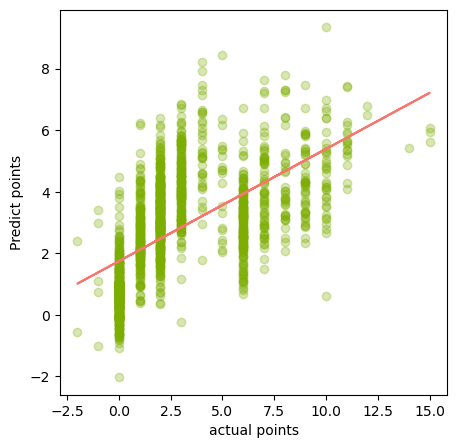

In [529]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_gks, y=y_lr_train_pred_gks, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_gks, y_lr_train_pred_gks, 1)
p = np.poly1d(z)

plt.plot(y_gks, p(y_gks), '#F8766D')
plt.ylabel('Predict points')
plt.xlabel('actual points')

## Fwds

In [532]:
from sklearn.linear_model import LinearRegression

In [534]:
reg_fwds = LinearRegression().fit(x_fwds, y_fwds)

In [536]:
y_lr_train_pred_fwds = reg_fwds.predict(x_fwds)
y_lr_test_pred_fwds = reg_fwds.predict(x_fwds_test)

In [538]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_fwds = mean_squared_error(y_fwds, y_lr_train_pred_fwds)
lr_train_r2_fwds = r2_score(y_fwds, y_lr_train_pred_fwds)

lr_test_mse_fwds = mean_squared_error(y_fwds_test, y_lr_test_pred_fwds)
lr_test_r2_fwds = r2_score(y_fwds_test, y_lr_test_pred_fwds)

In [540]:

print('LR MSE (Train): ', lr_train_mse_fwds)
print('LR R2 (Train): ', lr_train_r2_fwds)
print('LR MSE (Test): ', lr_test_mse_fwds)
print('LR R2 (Test): ', lr_test_r2_fwds)

LR MSE (Train):  1.2065022689782827
LR R2 (Train):  0.8833821555803865
LR MSE (Test):  1.7465589324112258
LR R2 (Test):  0.8416054467792677


Text(0.5, 0, 'Actual')

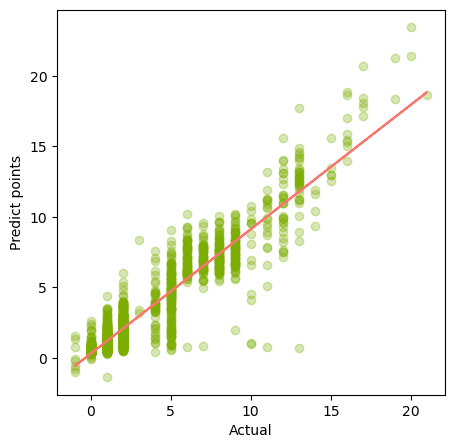

In [542]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_fwds, y=y_lr_train_pred_fwds, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_fwds, y_lr_train_pred_fwds, 1)
p = np.poly1d(z)

plt.plot(y_fwds, p(y_fwds), '#F8766D')
plt.ylabel('Predict points')
plt.xlabel('Actual')

In [23]:
from sklearn.linear_model import SGDRegressor

In [29]:
model = SGDRegressor(max_iter=2000, tol=None)

In [31]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(max_iter=2000, tol=None)

In [33]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2022-23/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

gks=df.loc[df['position']=="GK"]
defs=df.loc[df['position']=="DEF"]
mids=df.loc[df['position']=="MID"]
fwds=df.loc[df['position']=="FWD"]

y_gks=gks['total_points']
y_defs=defs['total_points']
y_mids=mids['total_points']
y_fwds=fwds['total_points']

x_gks=gks.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_defs=defs.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_mids=mids.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_fwds=fwds.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)

X_train_gks, X_test_gks, y_train_gks, y_test_gks = train_test_split(
  x_gks, y_gks, random_state=104,test_size=0.2, shuffle=False)

In [34]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(max_iter=2000, tol=None)

In [53]:
X_train_gks

,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
10,1.5,0,0,0,0,0.0,451,0.0,0.0,0.0,...,1,4,0.0,0,0,0,40,True,0,1
14,5.5,0,0,11,0,0.0,281,0.0,0.0,0.0,...,2,2,0.0,0,0,0,55,False,0,1
20,0.5,0,0,0,0,0.0,102,0.0,0.0,0.0,...,2,1,0.0,0,0,0,40,False,0,1
24,0.7,0,0,11,0,0.0,213,0.0,0.0,0.0,...,2,2,0.0,0,0,0,45,True,0,1
27,1.5,0,0,0,0,0.0,353,0.0,0.0,0.0,...,0,2,0.0,0,0,0,40,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21344,0.0,0,0,0,0,0.0,717,0.0,0.0,0.0,...,1,2,0.0,101,165,64,40,False,0,32
21347,0.0,0,0,0,0,0.0,644,0.0,0.0,0.0,...,0,0,0.0,5,97,92,40,True,0,32
21348,0.0,0,0,0,0,0.0,627,0.0,0.0,0.0,...,0,0,0.0,-10,0,10,40,False,0,32
21352,0.5,0,0,0,0,0.0,289,0.0,0.0,0.0,...,2,3,0.0,-136,191,327,40,True,0,32


In [37]:
y_pred = model.predict(X_test_gks)

In [49]:
y_pred

array([-1.21816645e+19, -1.08096990e+19, -2.24312309e+17, -5.17209638e+19,
       -3.76967980e+17, -9.45825972e+19, -2.44558553e+20, -1.57209775e+21,
       -2.06703272e+19, -6.07117484e+17, -1.14416633e+21, -2.37682905e+20,
       -1.18639806e+19, -5.52055589e+19, -2.94212531e+20, -1.05821561e+19,
       -7.08847006e+19, -1.18513959e+18, -2.89040100e+19, -5.54673071e+17,
       -1.19204416e+18, -3.96048572e+20, -2.63979064e+19, -2.99040125e+18,
       -3.21980748e+19, -7.84525575e+20, -4.33612358e+20, -1.17479570e+21,
       -1.35472687e+21, -3.00639113e+18, -1.20081089e+21, -1.09644824e+20,
       -8.80878342e+17, -9.43702095e+18, -5.10338068e+19, -4.12419352e+18,
       -8.80896275e+18, -3.17487387e+17, -1.20044279e+18, -8.44993090e+16,
       -7.27792291e+20, -2.02222248e+18, -2.03177515e+18, -5.18702249e+19,
       -1.10428313e+20, -2.83028480e+20, -4.98351213e+20, -9.26143390e+17,
       -1.02033094e+20, -3.65655176e+18, -8.17985418e+17, -9.14158062e+19,
       -1.70882158e+18, -

In [43]:

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_gks, y_pred)
r2 = r2_score(y_test_gks, y_pred)



In [45]:
mse

1.7030125561088398e+41

In [47]:
r2

-4.391584760684341e+40